# Построение рекомендательной системы книг с помощью LightGCN

In [1]:
import torch

## Исследование набора данных Book-Crossing

In [2]:
import pandas as pd

ratings = pd.read_csv("BX-Book-Ratings.csv", 
                      sep=';', encoding='latin-1')
users = pd.read_csv("BX-Users.csv", 
                    sep=';', encoding='latin-1')
books = pd.read_csv("BX-Books.csv", sep=';', 
                    encoding='latin-1', error_bad_lines=False)

/tmp/ipykernel_10272/1223433519.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv("BX-Books.csv", sep=';',


In [3]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [4]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [5]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


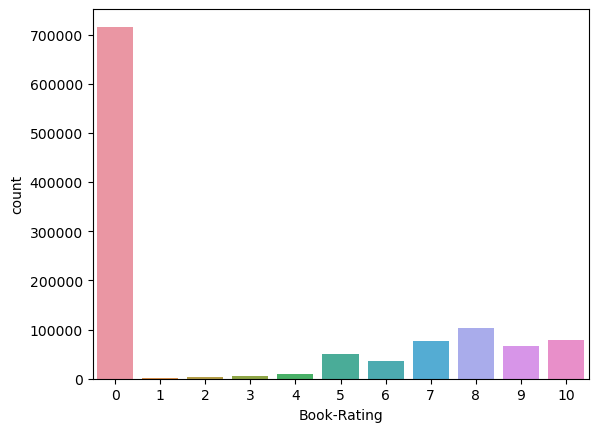

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.countplot(x=ratings['Book-Rating']);

In [7]:
print(len(ratings['User-ID'].unique())) 
print(len(ratings['ISBN'].unique())) 

105283
340556


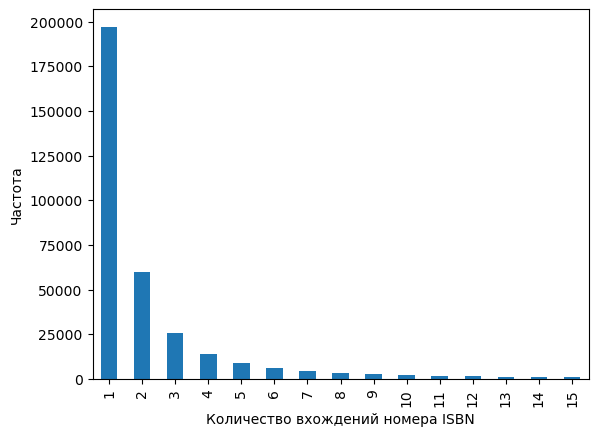

In [8]:
isbn_counts = ratings.groupby('ISBN').size()
count_occurrences = isbn_counts.value_counts()
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Количество вхождений номера ISBN")
plt.ylabel("Частота");

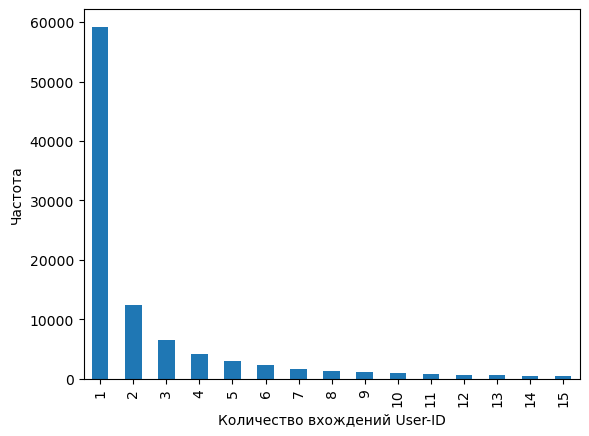

In [9]:
userid_counts = ratings.groupby('User-ID').size() 
count_occurrences = userid_counts.value_counts() 
count_occurrences[:15].plot(kind='bar')
plt.xlabel("Количество вхождений User-ID")
plt.ylabel("Частота");

## Предварительная обработка набора данных Book-Crossing

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [11]:
df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1') 
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1') 
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', 
                    error_bad_lines=False) 

# предварительная обработка
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & 
            df['User-ID'].isin(users['User-ID'].unique())]

# сохраняем 100k наивысших рейтингов
df = df[df['Book-Rating'] >= 8].iloc[:100000]

/tmp/ipykernel_10272/3793519247.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1',


In [12]:
# создаем отображения пользователей и товаров в целочисленные индексы
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# подсчитываем количество пользователей и товаров
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [13]:
# создаем матрицу смежности на основе рейтингов пользователей
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [14]:
# создаем обучающую, проверочную и тестовую матрицы смежности
train_index, test_index = train_test_split(
    range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(
    test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [15]:
def sample_mini_batch(edge_index):
    # генерируем BATCH_SIZE случайных индексов
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # генерируем индексы отрицательных примеров
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

## Реализация архитектуры LightGCN

In [16]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=dim_h
        )
        self.emb_items = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=dim_h
        )

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat(
            [self.emb_users.weight, self.emb_items.weight]
        )
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(
            torch.stack(embs, dim=1), dim=1
        )

        emb_users_final, emb_items_final = torch.split(
            emb_final, [self.num_users, self.num_items]
        )

        return (
            emb_users_final, 
            self.emb_users.weight, 
            emb_items_final, 
            self.emb_items.weight
        )

In [17]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, 
             emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (
        emb_users.norm().pow(2) + 
        emb_pos_items.norm().pow(2) +
        emb_neg_items.norm().pow(2)
    )

    pos_ratings = torch.mul(
        emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(
        emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(
        torch.nn.functional.softplus(pos_ratings - neg_ratings)
    )
    # bpr_loss = torch.mean(
    #     torch.nn.functional.logsigmoid(pos_ratings - neg_ratings)
    #)

    return -bpr_loss + reg_loss

In [18]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [19]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array(
        [len(items_ground_truth[i]) for i in range(len(items_ground_truth))]
    )

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [20]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [21]:
# функция-обертка для получения метрик качества
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # получаем топ-k рекомендованных товаров для каждого пользователя
    _, top_K_items = torch.topk(ratings, k=K)

    # получаем всех уникальных пользователей в оцененном нами наборе
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # преобразовываем словарь положительных товаров
    # для тестового пользователя в список
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users
    ]

    # определяем правильность топ-k прогнозов
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [22]:
# функция-обертка для оценки качества модели
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(
        edge_index
    )
    user_indices, pos_item_indices, neg_item_indices = (
        structured_negative_sampling(edge_index, 
                                     contains_neg_self_loops=False)
    )

    emb_users_final, emb_users = (
        emb_users_final[user_indices], 
        emb_users[user_indices]
    )

    emb_pos_items_final, emb_pos_items = (
        emb_items_final[pos_item_indices], 
        emb_items[pos_item_indices]
    )
    emb_neg_items_final, emb_neg_items = (
        emb_items_final[neg_item_indices], 
        emb_items[neg_item_indices]
    )

    loss = bpr_loss(
        emb_users_final, 
        emb_users, 
        emb_pos_items_final, 
        emb_pos_items, 
        emb_neg_items_final, 
        emb_neg_items
    ).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [23]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(
            train_edge_index
        )

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
            train_edge_index
        )
        
        emb_users_final, emb_users = (
            emb_users_final[user_indices], 
            emb_users[user_indices]
        )
        emb_pos_items_final, emb_pos_items = (
            emb_items_final[pos_item_indices], 
            emb_items[pos_item_indices]
        )
        emb_neg_items_final, emb_neg_items = (
            emb_items_final[neg_item_indices], 
            emb_items[neg_item_indices]
        )

        train_loss = bpr_loss(
            emb_users_final, 
            emb_users, 
            emb_pos_items_final, 
            emb_pos_items, 
            emb_neg_items_final, 
            emb_neg_items
        )

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(
            model, val_edge_index, [train_edge_index]
        )
        print(
            f"Эпоха {epoch} \n| Функция потерь - обуч. набор: "
            f"{train_loss.item():.5f} | "
            f"Функция потерь - проверочн. набор: {val_loss:.5f} \n| "
            f"Recall@{K} - проверочн. набор: {recall:.5f} | "
            f"Ndcg@{K} - проверочн. набор: {ndcg:.5f}"
        )

Эпоха 0 
| Функция потерь - обуч. набор: -0.69345 | Функция потерь - проверочн. набор: -0.69255 
| Recall@20 - проверочн. набор: 0.00985 | Ndcg@20 - проверочн. набор: 0.00567
Эпоха 5 
| Функция потерь - обуч. набор: -0.73150 | Функция потерь - проверочн. набор: -0.63679 
| Recall@20 - проверочн. набор: 0.01870 | Ndcg@20 - проверочн. набор: 0.00921
Эпоха 10 
| Функция потерь - обуч. набор: -0.96728 | Функция потерь - проверочн. набор: -0.42531 
| Recall@20 - проверочн. набор: 0.01859 | Ndcg@20 - проверочн. набор: 0.00919
Эпоха 15 
| Функция потерь - обуч. набор: -1.35675 | Функция потерь - проверочн. набор: -0.02465 
| Recall@20 - проверочн. набор: 0.01889 | Ndcg@20 - проверочн. набор: 0.00931
Эпоха 20 
| Функция потерь - обуч. набор: -2.22876 | Функция потерь - проверочн. набор: 0.52749 
| Recall@20 - проверочн. набор: 0.01863 | Ndcg@20 - проверочн. набор: 0.00918
Эпоха 25 
| Функция потерь - обуч. набор: -3.23828 | Функция потерь - проверочн. набор: 1.19839 
| Recall@20 - проверочн. н

In [26]:
test_loss, test_recall, test_ndcg = test(
    model, test_edge_index.to(device), 
    [train_edge_index, val_edge_index]
)

print(
    f"Функция потерь - тест. набор: {test_loss:.5f} | "
    f"Recall@{K} - тест. набор: {test_recall:.5f} | "
    f"Ndcg@{K} - тест. набор: {test_ndcg:.5f}"
)

Функция потерь - тест. набор: 1.94753 | Recall@20 - тест. набор: 0.01716 | Ndcg@20 - тест. набор: 0.00908


## Рекомендация книг для конкретного пользователя

In [27]:
bookid_title = pd.Series(books['Book-Title'].values, 
                         index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, 
                          index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [30]:
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices 
           if index in user_pos_items[user]][:num_recs]
    item_isbns = [
        list(item_mapping.keys())[list(item_mapping.values()).index(book)] 
        for book in ids
    ]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Любимые книги для пользователя n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices 
           if index not in user_pos_items[user]][:num_recs]
    item_isbns = [
        list(item_mapping.keys())[list(item_mapping.values()).index(book)] 
        for book in ids
    ]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nРекомендованные книги для пользователя n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    user_agent_value = ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                        'AppleWebKit/537.36 (KHTML, like Gecko) '
                        'Chrome/58.0.3029.110 Safari/537.3')

    headers = {'User-Agent': user_agent_value}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[
            df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]
        ]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

Любимые книги для пользователя n°277427:
- The Da Vinci Code, by Dan Brown
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich
- Into the Wild, by Jon Krakauer

Рекомендованные книги для пользователя n°277427
- The Lovely Bones: A Novel, by Alice Sebold
- The Red Tent (Bestselling Backlist), by Anita Diamant
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- To Kill a Mockingbird, by Harper Lee
- Life of Pi, by Yann Martel


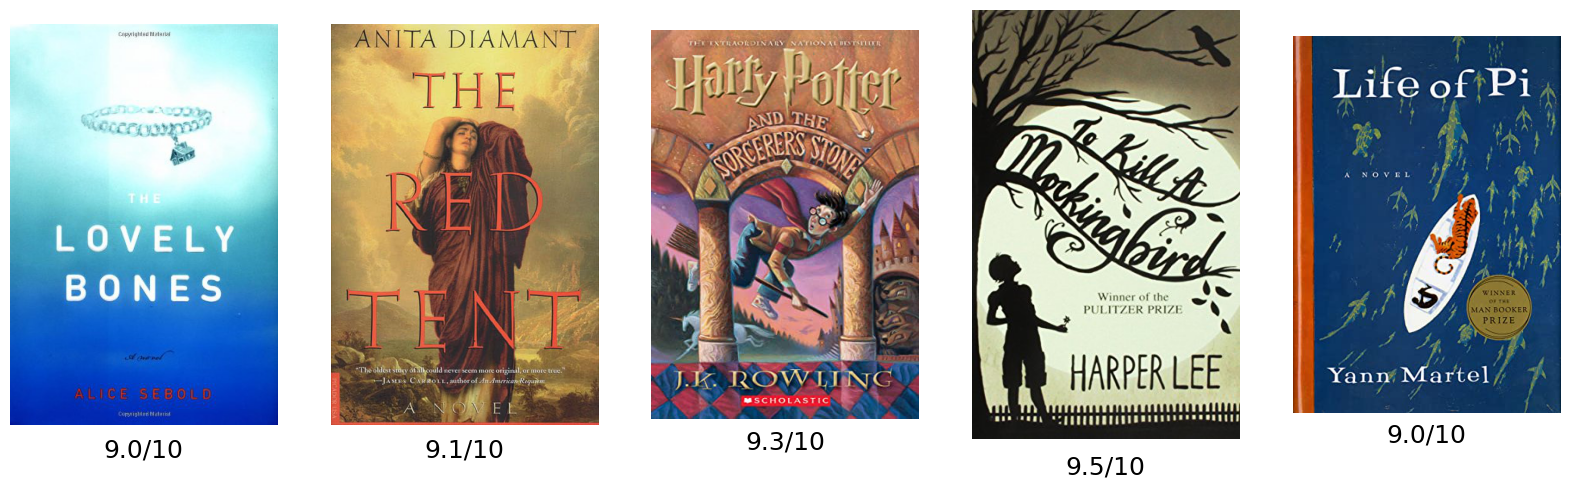

In [31]:
recommend(277427, 5)